<a href="https://colab.research.google.com/github/mohripan/Machine-Learning/blob/main/AdvanceHouseRegressionWithPytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [113]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

In [114]:
train = pd.read_csv('https://raw.githubusercontent.com/mohripan/Machine-Learning/main/House%20Prediction%20Advanced/train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/mohripan/Machine-Learning/main/House%20Prediction%20Advanced/test.csv')

df = pd.concat([train, test])

In [115]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 0 to 1458
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   MSZoning       2915 non-null   object 
 3   LotFrontage    2433 non-null   float64
 4   LotArea        2919 non-null   int64  
 5   Street         2919 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2919 non-null   object 
 8   LandContour    2919 non-null   object 
 9   Utilities      2917 non-null   object 
 10  LotConfig      2919 non-null   object 
 11  LandSlope      2919 non-null   object 
 12  Neighborhood   2919 non-null   object 
 13  Condition1     2919 non-null   object 
 14  Condition2     2919 non-null   object 
 15  BldgType       2919 non-null   object 
 16  HouseStyle     2919 non-null   object 
 17  OverallQual    2919 non-null   int64  
 18  OverallC

In [116]:
df = df.drop('SalePrice', axis=1)
df = df.drop('Id', axis=1)

In [117]:
def fill_data(data):
  data_type = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

  for i in data.columns:
    if data[i].dtype in data_type:
      data[i].fillna(data[i].median(), inplace=True)

    elif data[i].dtype == 'object':
      data[i].fillna('None', inplace=True)

  return data

In [118]:
df = fill_data(df)

In [119]:
df = pd.get_dummies(df)

In [120]:
X = np.array(df)

In [121]:
sc_x = StandardScaler()
X = sc_x.fit_transform(X)

In [122]:
X_train = X[:len(train), :]
X_test = X[len(train):, :]

In [123]:
X_train.shape

(1460, 310)

In [124]:
y = train['SalePrice'].values.reshape(-1, 1)

In [125]:
y = np.log1p(y)

In [126]:
sc_y = StandardScaler()
y = sc_y.fit_transform(y)

In [127]:
X_train = X_train.astype(np.float32)
y = y.astype(np.float32)

In [128]:
train_X, test_X, train_y, test_y = train_test_split(X_train, y, test_size=0.25)

In [129]:
class Dataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __getitem__(self, index):
    return self.X[index], self.y[index]

  def __len__(self):
    return len(self.X)

In [130]:
train_dataset = Dataset(train_X, train_y)
test_dataset = Dataset(test_X, test_y)

In [131]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [132]:
class ANN(nn.Module):
  def __init__(self, num_input):
    super(ANN, self).__init__()
    self.fc1 = nn.Linear(num_input, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 128)
    self.fc4 = nn.Linear(128, 128)
    self.fc5 = nn.Linear(128, 128)
    self.fc6 = nn.Linear(128, 1)

  def forward(self, X):
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = F.relu(self.fc3(X))
    X = F.relu(self.fc4(X))
    X = F.relu(self.fc5(X))
    X = self.fc6(X)
    return X

In [133]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ANN(train_X.shape[1]).to(device)

In [134]:
!pip install madgrad

In [135]:
from madgrad import MADGRAD

In [136]:
criterion = nn.MSELoss()
optimizer = MADGRAD(model.parameters())

In [137]:
def training(num_epochs):
  train_losses = np.zeros(num_epochs)
  test_losses = np.zeros(num_epochs)

  loss_simpan = 100

  for i in range(num_epochs):
    train_loss = []

    for batch_idx, (data, target) in enumerate(train_loader):
      optimizer.zero_grad()

      data, target = data.to(device), target.to(device)

      score = model(data)
      loss = criterion(score, target)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    train_losses[i] = np.mean(train_loss)
    test_loss = []

    for batch_idx, (data, target) in enumerate(test_loader):
      data, target = data.to(device), target.to(device)

      score = model(data)
      loss = criterion(score, target)

      test_loss.append(loss.item())

    test_losses[i] = np.mean(test_loss)

    print(f'Epoch: {i+1}/{num_epochs}, train loss: {np.mean(train_loss):.4f}, test loss: {np.mean(test_loss):.4f}')

    if np.mean(test_loss) < loss_simpan:
      torch.save({'epoch': i,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': np.mean(test_loss),
            }, 'model.pth')
      loss_simpan = np.mean(test_loss)
      print('Model Saved')

  return train_losses, test_losses

In [138]:
train_losses, test_losses = training(150)

Epoch: 1/150, train loss: 0.5510, test loss: 0.1747
Model Saved
Epoch: 2/150, train loss: 0.2282, test loss: 0.3934
Epoch: 3/150, train loss: 0.1933, test loss: 0.2295
Epoch: 4/150, train loss: 0.2765, test loss: 0.2919
Epoch: 5/150, train loss: 0.2202, test loss: 0.1674
Model Saved
Epoch: 6/150, train loss: 0.2114, test loss: 0.2059
Epoch: 7/150, train loss: 0.1717, test loss: 0.0999
Model Saved
Epoch: 8/150, train loss: 0.0920, test loss: 0.1578
Epoch: 9/150, train loss: 0.1688, test loss: 0.1419
Epoch: 10/150, train loss: 0.0943, test loss: 0.1788
Epoch: 11/150, train loss: 0.1128, test loss: 0.1305
Epoch: 12/150, train loss: 0.0613, test loss: 0.1146
Epoch: 13/150, train loss: 0.0745, test loss: 0.1592
Epoch: 14/150, train loss: 0.0600, test loss: 0.1284
Epoch: 15/150, train loss: 0.0750, test loss: 0.1055
Epoch: 16/150, train loss: 0.0657, test loss: 0.1331
Epoch: 17/150, train loss: 0.0627, test loss: 0.1239
Epoch: 18/150, train loss: 0.0798, test loss: 0.1246
Epoch: 19/150, trai

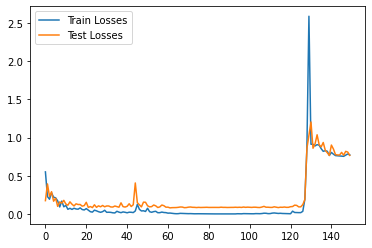

In [139]:
plt.plot(train_losses, label='Train Losses')
plt.plot(test_losses, label='Test Losses')
plt.legend()

In [141]:
model = ANN(train_X.shape[1]).to(device)

criterion = nn.MSELoss()
optimizer = MADGRAD(model.parameters())

checkpoint = torch.load('model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [142]:
def get_pred(data):
  model.eval()

  with torch.no_grad():
    
    score = model(data)

    return score.cpu().numpy()

In [144]:
pred = get_pred(torch.from_numpy(test_X).to(device))

In [145]:
from sklearn.metrics import r2_score

In [146]:
r2_score(test_y, pred)

0.9162417706631605

In [148]:
X_test = X_test.astype(np.float32)

In [149]:
score_pred = get_pred(torch.from_numpy(X_test).to(device))
score_pred

array([[-0.53980315],
       [-0.13009965],
       [ 0.352833  ],
       ...,
       [ 0.17225116],
       [-0.7790084 ],
       [ 0.5444818 ]], dtype=float32)

In [150]:
score_pred = sc_y.inverse_transform(score_pred)
score_pred = np.expm1(score_pred)

In [152]:
score_pred = score_pred*1.001619

In [156]:
score_pred = score_pred.reshape(-1, )

In [157]:
submission = pd.DataFrame({'Id': test['Id'], 'SalePrice':score_pred})

In [158]:
submission

,Id,SalePrice
0,1461,134607.343750
1,1462,158533.046875
2,1463,192251.734375
3,1464,198385.515625
4,1465,191543.671875
...,...,...
1454,2915,95285.890625
1455,2916,89168.703125
1456,2917,178876.562500
1457,2918,122344.890625


In [159]:
submission.to_csv('submission.csv', index=False)